# Plan

## fMRI data extraction portion

1. get gray matter. 
2. normalize data. 
3. grab stable block data. 
3. estimate variance roughly (as if it was from normal). 
4. given image, get coordinates and transform into nodes/edges
5. run prior simulation (save movie?). See if beta=1 still reasonable given 3D? E.g. looks like brain data. 
6. K-means
6. MEMC-HMRF 


['n8' 'n10' 'n13' 'n14' 'n20' 'n21' 'n22' 'n23' 'n24' 'n25' 'n28' 'n32'
 'n33' 'n34' 'n35' 'n41' 'n42']

# Imports

In [1]:
import nibabel as nib
import nipy as nipy
import os
import glob
import numpy as np
import nilearn as nil

from nilearn.input_data import NiftiMasker
import scipy
import pickle
from scipy import stats
from sklearn import linear_model
import re
import pandas as pd
import os
from nipy.modalities.fmri.utils import events, Symbol, lambdify_t
from nipy.modalities.fmri.hrf import glover
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn import image
import copy
from matplotlib.backends.backend_pdf import PdfPages
import scipy.linalg as spl
from nipy.modalities.fmri.hemodynamic_models import compute_regressor, _orthogonalize
from nipy.modalities.fmri.design_matrix import _make_drift

from nilearn.image.image import mean_img
### Show results ##############################################################
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

from nitime.analysis import SpectralAnalyzer, FilterAnalyzer
from nitime.timeseries import TimeSeries
import h5py

import nilearn.plotting.img_plotting
import nilearn.plotting.displays
reload(nilearn.plotting.displays)
from nilearn.plotting.img_plotting import plot_epi, plot_roi,plot_stat_map
%matplotlib inline

import networkx as nx

In [ ]:
def plot_img_4_rows(img,threshold=0,title=None,vmax=None):

    slices = np.linspace(-44,55,32)

    f = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(8, 2)
    #print('here')

    ax = plt.subplot(gs[0:2, :])
    display = plot_stat_map(img,threshold=threshold,display_mode='z', cut_coords=slices[0:8],axes=ax,title=title,vmax=vmax)

    ax = plt.subplot(gs[2:4, :])
    display = plot_stat_map(img,threshold=threshold,display_mode='z', cut_coords=slices[8:16],axes=ax,title=title,vmax=vmax)

    ax = plt.subplot(gs[4:6, :])
    display = plot_stat_map(img,threshold=threshold,display_mode='z', cut_coords=slices[16:24],axes=ax,title=title,vmax=vmax)

    ax = plt.subplot(gs[6:8, :])
    display = plot_stat_map(img,threshold=threshold,display_mode='z', cut_coords=slices[24:32],axes=ax,title=title,vmax=vmax)



### Get data / Mask / Normalize

In [6]:
sub = 'n10'
analysisdir = '/home/bishop/studies/AnxLearn2/anxlearn_fmri/input_epi/'
filename = analysisdir+sub+'/pain/preprocessed_nounwarp.feat/prefiltered_func_data_smooth.nii.gz'
filenames=glob.glob(filename)
nifti_masker = NiftiMasker( mask_strategy='epi',standardize=True,detrend=True)
nifti_masker.fit(filenames[0])

NiftiMasker(detrend=True, high_pass=None, low_pass=None, mask_args=None,
      mask_img=None, mask_strategy='epi', memory=Memory(cachedir=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

In [7]:
fmri_masked_flat = nifti_masker.transform(filenames[0])

### Take A look at Data 

In [8]:
fmri_masked_flat.shape

(1086, 61398)

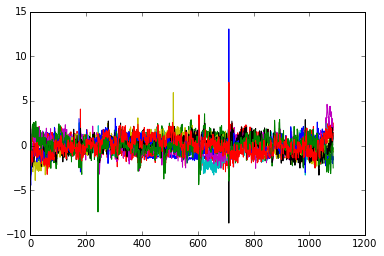

In [9]:
plt.plot(fmri_masked_flat[:,np.random.randint(fmri_masked_flat.shape[1],size=10)])

In [58]:
#fmri_masked_image2 = nifti_masker.inverse_transform(fmri_masked_flat*2)

In [61]:
#fmri_masked_image2.to_filename('test.nii')

### Index Image

In [10]:
index_image = nifti_masker.inverse_transform(np.arange(fmri_masked_flat.shape[1]))

In [11]:
index_image_data= index_image.get_data()
index_image_data.shape

(98, 98, 31)

In [12]:
np.where(index_image_data==100)

(array([22]), array([42]), array([12]))

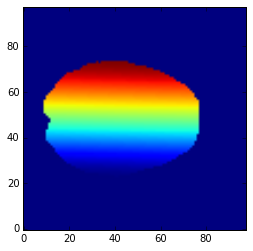

In [13]:
plt.imshow(index_image_data[:,:,20],origin='lower') # cmap='gray'

### Graph 

In [57]:
s = np.shape(index_image_data)
G = nx.grid_graph(dim=[s[0],s[1],s[2]])

### Prune Graph

In [60]:
for d1 in range(s[0]):
    for d2 in range(s[1]):
        for d3 in range(s[2]):
            if index_image_data[d1,d2,d3]==0:
                G.remove_node((d1,d2,d3))

In [61]:
G.edge[(70,34,14)]

{(69, 34, 14): {},
 (70, 33, 14): {},
 (70, 34, 13): {},
 (70, 34, 15): {},
 (70, 35, 14): {},
 (71, 34, 14): {}}

In [62]:
len(G.node)

61397

### Get Mean Image


In [16]:

mean_func_img = mean_img(filenames[0])

### ICA

In [17]:
#from sklearn.decomposition import FastICA
#n_components = 7
#ica = FastICA(n_components=n_components, random_state=42)
#components_masked = ica.fit_transform(fmri_masked_flat.T).T



In [18]:
#components_masked.shape

(7, 61398)

In [22]:
#components = nifti_masker.inverse_transform(components_masked)



In [21]:
#for comp in range(7):
#    index_img(components, comp).to_filename('ICA'+str(comp)+'.nii')

In [89]:
#plot_img_4_rows(index_img(components, 1),threshold=0.001,vmax=0.02)

### Choose 7 Clusters

In [90]:
num_states = 7

### K-Means

In [ ]:
#from sklearn.cluster import KMeans 
#kmeans = KMeans(num_states)

In [31]:
#results = kmeans.fit(fmri_masked_flat.T) #time second argument

In [32]:
#labels = results.fit_predict(fmri_masked_flat.T)


In [33]:
#labels_image = nifti_masker.inverse_transform(labels)


In [34]:
#labels.shape


(61398,)

In [58]:
labels_image.to_filename('Kclust.nii')

In [91]:
#plot_img_4_rows(labels_image,threshold=0,vmax=10)

In [38]:
cluster_time_series = results.cluster_centers_.T

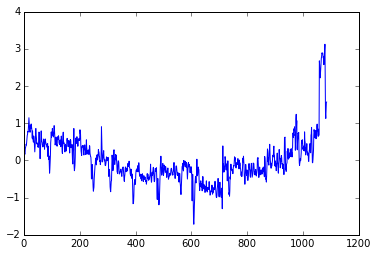

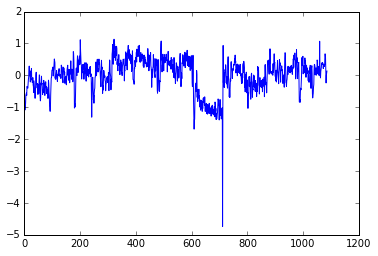

In [92]:
for i in range(2):
    plt.figure()
    plt.plot(cluster_time_series[:,i])

### Add Data to Graph

In [65]:
fmri_masked_flat.shape

(1086, 61398)

In [66]:
for node in G.nodes():
    G.node[node]['x'] = fmri_masked_flat[:,index_image_data[node[0],node[1],node[2]]]

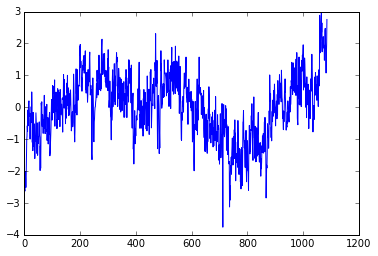

In [68]:
plt.plot(G.node[node]['x'])

In [81]:
G.graph['img_shape']= index_image_data.shape

In [93]:
G.graph['num_states'] = num_states


In [143]:
G.graph['tp']= fmri_masked_flat.shape[0]

In [116]:
G.graph['num_nodes'] = fmri_masked_flat.shape[1]

### Add K-means states 

In [78]:
labels.shape

(61398,)

In [80]:
for node in G.nodes():
    G.node[node]['state'] = labels[index_image_data[node[0],node[1],node[2]]]
    G.node[node]['kstate'] = labels[index_image_data[node[0],node[1],node[2]]]
    

### Plot Slice of Labels


In [86]:
def plot_graph(G,slicee):
    im = np.empty((G.graph['img_shape'][0],G.graph['img_shape'][1]))
    for node in G.node:
        if node[2]==slicee:
            im[node[0],node[1]]=G.node[node]['state']

    imm = plt.imshow(im,interpolation='None',origin='lower')
    return(imm)


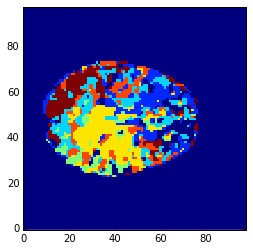

In [87]:
plot_graph(G,20)

### MRF Functions


In [100]:
def prior_energy(G,node,z):
    # needs state z, 
    # counts number of non-matches.. non matches increase energy 
    neighbor_voxel_matches = 0
    for edge in G.edge[node]:
        if z!=G.node[edge]['state']:
            neighbor_voxel_matches+=1
    return(neighbor_voxel_matches* G.graph['B'])


In [101]:
def node_conditional(G,node,prior_or_posterior):
    energy_per_state =  np.zeros(G.graph['num_states'])
    for s,state in enumerate(range(G.graph['num_states'])):
        if prior_or_posterior=='posterior':
            lik_energy=liklihood_energy(G,node,state)
        elif prior_or_posterior=='prior':
            lik_energy=0
        energy_per_state[s] = np.exp(-1.0*prior_energy(G,node,state)+lik_energy)
    return(energy_per_state/energy_per_state.sum())
                                     

In [170]:
def liklihood_energy(G,node,z):
    k = G.graph['tp']
    #Sigma = np.eye(k)*G.graph['sigma_est'] # use true sigma for now 
    u = G.graph['u_est'][:,z] # 1x time points
    x =  G.node[node]['x'] # 1 x time points
    #lik_en = -0.5*np.log(1.0) - 0.5*np.dot(np.dot((u-x),np.eye(k)),(u-x).T) - k/2.0*np.log(2.0*np.pi)
    lik_en = -0.5*np.log(1.0) - 0.5*np.sum((u-x)**2) - k/2.0*np.log(2.0*np.pi)
    return(lik_en)


In [136]:
#### Gibbs sample from prior 
def gibbs_sample(G,num_gibbs_samples=1,prior_or_posterior='prior'):

    posterior_samples = np.zeros((G.graph['num_nodes'],num_gibbs_samples))
    for samples in range(num_gibbs_samples):
        for n,node in enumerate(G.nodes()):
            cond_probs = node_conditional(G,node,prior_or_posterior)
            G.node[node]['state']=np.where(np.random.multinomial(1,cond_probs))[0][0]
            posterior_samples[n,samples] = G.node[node]['state']
    return(G,posterior_samples)


### Set B and Sample from Potts



In [110]:
G.graph['B'] = 1.0

In [113]:
energies = np.array([])
for node in G.nodes():
    energies = np.append(energies,prior_energy(G,node,1))

(array([   435.,   1331.,      0.,   2469.,      0.,   4771.,   6456.,
             0.,  10620.,  35315.]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ]),
 <a list of 10 Patch objects>)

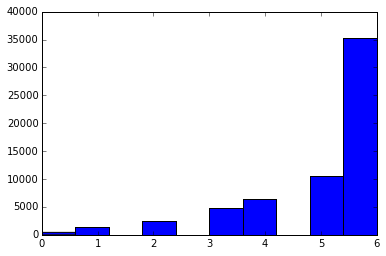

In [114]:
plt.hist(energies)

In [164]:
%time G,posterior_samples = gibbs_sample(G,num_gibbs_samples=2,prior_or_posterior='posterior')

CPU times: user 13.4 s, sys: 14 ms, total: 13.4 s
Wall time: 13.5 s


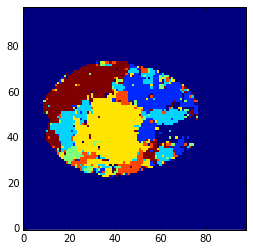

In [158]:
plot_graph(G,20)

In [127]:
nx.write_gpickle(G, "G.gpickle")

In [141]:
(20*4*5)/60

6

## Use K-means for u-est

In [145]:
cluster_time_series.shape

(1086, 7)

In [153]:
G.graph['u_est'] = cluster_time_series
G.graph['u_est'].shape

(1086, 7)

In [99]:
G.graph['sigma_est'] = 1.0

In [ ]:
(30*5*4)/60

### EM 

In [171]:
%time G,posterior_samples = gibbs_sample(G,1,prior_or_posterior='posterior')

CPU times: user 18.1 s, sys: 4 ms, total: 18.1 s
Wall time: 18.1 s


In [172]:
for em_step in range(3):
    print('em: '+str(em_step))

        
    u_est_new =G.graph['u_est']
    u_est_new_count = G.graph['u_est']*0.0+1
    
    for gs in range(5):
        print('gibbs: '+str(gs))
        G,posterior_samples = gibbs_sample(G,1,prior_or_posterior='posterior')
    
        for n,node in enumerate(G.node):
            state = posterior_samples[n] # node was in this state
            u_est_new[:,int(state)] += G.node[node]['x'] # add the x data to that time vector
            u_est_new_count[:,int(state)] += np.ones(G.graph['tp'])
            
    u_est_new = u_est_new/u_est_new_count        
    G.graph['u_est'] = u_est_new

em: 0
gibbs: 0
gibbs: 1
gibbs: 2
gibbs: 3
gibbs: 4
em: 1
gibbs: 0
gibbs: 1
gibbs: 2
gibbs: 3
gibbs: 4
em: 2
gibbs: 0
gibbs: 1
gibbs: 2
gibbs: 3
gibbs: 4


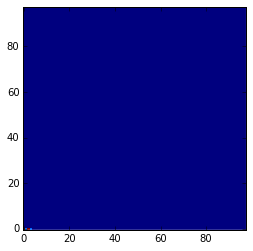

In [173]:
plot_graph(G,20)

### Save Brain

In [161]:
states = np.zeros(np.shape(labels))
for node in G.nodes():
    states[index_image_data[node[0],node[1],node[2]]] = G.node[node]['state'] 

In [162]:
states_image = nifti_masker.inverse_transform(states)

In [163]:
states_image.to_filename('MRFclust'+sub+'.nii')